This notebook shows how to create a simple forward-only network using hls4ml. We will exlore later what we need to change to turn it into a network that has the ability to perform backprop

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/fpga/cad/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:/usr/lib32:'

2023-01-24 17:34:02.264860: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:/fpga/cad/intel/intelFPGA_lite/20.1/hls/host/linux64/lib:/usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:/usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:/usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:/usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:/usr/lib/gcc/x86_64-linux-gnu/9/:/usr/lib/gcc/x86_64-linux-gnu/4.9.3/:
2023-01-24 17:34:02.264881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Let's load a very dummy dataset 

In [31]:
ds_dir = "../../datasets/dummy_linear_half"

load = lambda x: np.load(os.path.join(ds_dir,x))
X_train_val = load('X_train_val.npy')
X_test = load('X_test.npy')
y_train_val = load('y_train_val.npy')
y_test = load('y_test.npy')
#classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [33]:
del model
model = Sequential()
model.add(QDense(1, input_shape=(1,), 
                name='fc1',
                kernel_quantizer=quantized_bits(6,0,alpha=1), 
                bias_quantizer=quantized_bits(6,0,alpha=1),
                kernel_initializer='lecun_uniform', 
                kernel_regularizer=l1(0.0001),
                use_bias = False))
# model.add(QActivation(activation=quantized_relu(6), name='relu1'))
# model.add(QDense(32, name='fc2',
#                  kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
#                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(QActivation(activation=quantized_relu(6), name='relu2'))
# model.add(QDense(32, name='fc3',
#                  kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
#                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(QActivation(activation=quantized_relu(6), name='relu3'))
# model.add(QDense(5, name='output',
#                  kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
#                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [34]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [35]:
train = True
if train:
    adam = Adam(lr=0.1)
    model.compile(optimizer=adam, loss=['mse'], metrics=['mse'])

    # Get reference pretrained predictions 
    y_ref_pretrained = model.predict(np.ascontiguousarray(X_test))

    # callbacks = all_callbacks(stop_patience = 1000,
    #                           lr_factor = 0.5,
    #                           lr_patience = 10,
    #                           lr_epsilon = 0.000001,
    #                           lr_cooldown = 2,
    #                           lr_minimum = 0.0000001,
    #                           outputDir = 'model_dummy_forward')
    callbacks = all_callbacks(stop_patience = 10000000, outputDir = 'model_dummy_forward')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=16,
              epochs=80, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_dummy_forward/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_dummy_forward/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/80


2023-01-24 17:40:10.192744: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-24 17:40:10.192768: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-24 17:40:10.192817: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


  1/375 [..............................] - ETA: 2:14 - loss: 0.0915 - mse: 0.0914WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0005s vs `on_train_batch_end` time: 0.0073s). Check your callbacks.


2023-01-24 17:40:10.591773: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-24 17:40:10.591795: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-24 17:40:10.620199: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-24 17:40:10.620804: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-24 17:40:10.621850: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: model_dummy_forward/logs/train/plugins/profile/2023_01_24_17_40_10
2023-01-24 17:40:10.622435: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to model_dummy_forward/logs/train/plugins/profile/2023_01_24_17_40_10/kona-ubuntu.trace.json.gz
2023-01-24 17:40:10.623331: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: model_dummy_forward/logs/train/plugins/

375/375 [==============================] - 1s 1ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 4.8632e-05 - val_mse: 0.0000e+00

***callbacks***
saving losses to model_dummy_forward/losses.log

Epoch 00001: val_loss improved from inf to 0.00005, saving model to model_dummy_forward/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 0.00005, saving model to model_dummy_forward/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_dummy_forward/KERAS_check_model_last.h5

Epoch 00001: saving model to model_dummy_forward/KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 2/80
375/375 [==============================] - 0s 629us/step - loss: 7.1133e-05 - mse: 2.1362e-05 - val_loss: 4.9578e-05 - val_mse: 0.0000e+00

***callbacks***
saving losses to model_dummy_forward/losses.log

Epoch 00002: val_loss did not improve from 0.00005

Epoch 00002: val_loss did not improve from 0.00005

Epoch 00002: saving model to model_dummy_forward/KERAS_check_model

In [36]:
import hls4ml
import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_dummy_forward/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: QDense
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<6,1>
      bias:          ap_fixed<6,1>
    ReuseFactor:     1
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done


(8.825657423585654e-05, 1.1997992453958632)

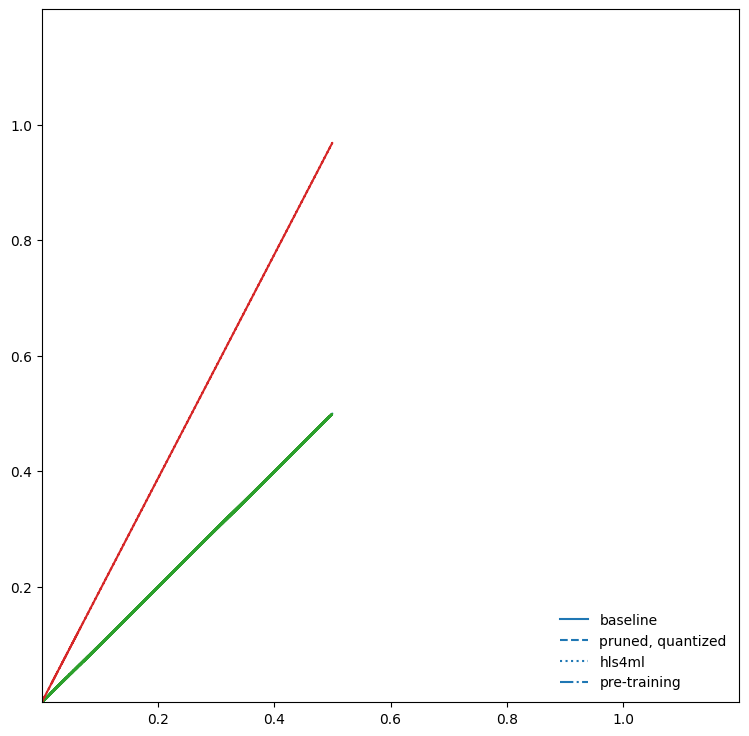

In [40]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_dummy_forward/KERAS_check_best_model.h5', custom_objects={"QDense": QDense})
y_pred = model_ref.predict(X_test)

fig, ax = plt.subplots(figsize=(9, 9))
plt.plot(y_test, y_pred)
#plt.gca().set_prop_cycle(None) # reset the colors
plt.plot(y_test, y_qkeras, linestyle='--')
#plt.gca().set_prop_cycle(None) # reset the colors
plt.plot(y_test, y_hls, linestyle=':')
#plt.gca().set_prop_cycle(None) # reset the colors
plt.plot(y_test, y_ref_pretrained, linestyle='-.')


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml', 'pre-training'],
            loc='lower right', frameon=False)
ax.add_artist(leg)


xmax = 1.2*np.max([np.max(X_test), np.max(y_test),np.max(y_ref_pretrained),np.max(y_pred)])
xmin = 0.8*np.min([np.min(X_test), np.min(y_test),np.min(y_ref_pretrained),np.min(y_pred)])

ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)




In [38]:
np.hstack((X_test,y_test,y_pred))

array([[0.03517368, 0.01758684, 0.01758684],
       [0.9503029 , 0.47515145, 0.47515145],
       [0.30934059, 0.15467029, 0.1546703 ],
       ...,
       [0.07545041, 0.0377252 , 0.0377252 ],
       [0.50679444, 0.25339722, 0.25339723],
       [0.13754017, 0.06877009, 0.06877009]])

In [39]:
model.layers[0].get_weights()

[array([[0.48445025]], dtype=float32)]

In [42]:
hls_model.build(reset=False, csim=False, synth=True, cosim=True, validation=False, export=False, vsynth=False)